Dataset Preview:
                  Date  Total Sales (PHP)  Insecticides Sales  \
0  2010-01-31 00:00:00              48133                8491   
1  2010-01-31 00:00:00              46600               13882   
2  2010-01-31 00:00:00              37543                7733   
3  2010-01-31 00:00:00              37072                5034   
4  2010-01-31 00:00:00              31973               10605   

   Fertilizers Sales  Herbicides Sales  Promo Active  Holiday/Season  \
0              13674              6460             1               1   
1               8452              5632             0               0   
2              13060              7447             1               0   
3              17658              3203             1               1   
4              18503              3535             1               1   

   Economic Indicator  Year  Month  
0          101.802412  2010      1  
1           98.362194  2010      1  
2          100.959799  2010      1  
3          

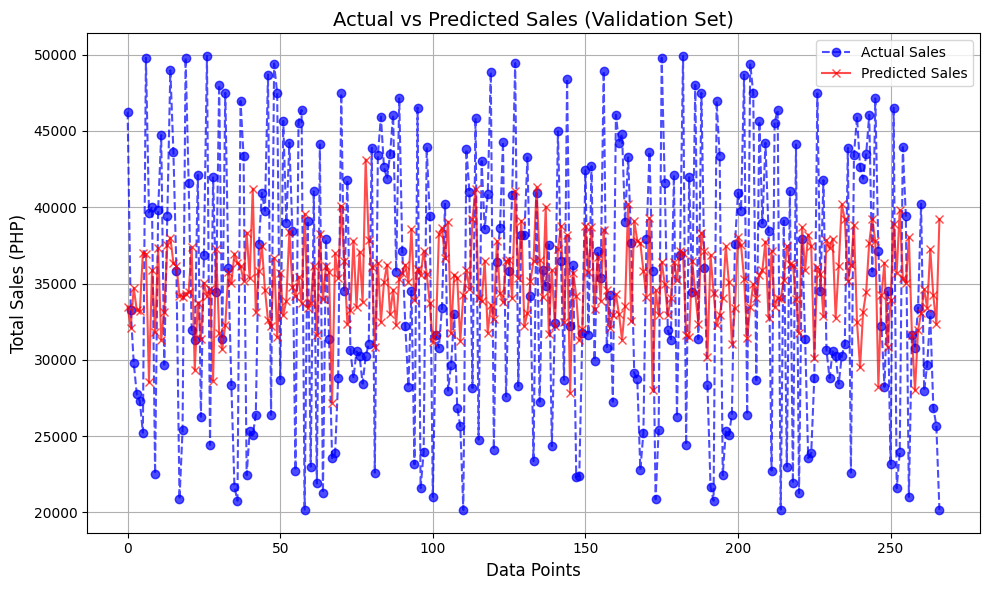

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
import joblib

# Load your dataset
file_path = r'sales_data\extended_sales_data_2010_2024.xlsx'  # Adjust the file path
data = pd.read_excel(file_path)

# Display the first few rows to inspect the data
print("Dataset Preview:")
print(data.head())

# Handle missing values for numeric columns
numeric_columns = data.select_dtypes(include=[np.number]).columns
data[numeric_columns] = data[numeric_columns].fillna(data[numeric_columns].mean())

# Feature Engineering: Create a lag column for previous month's sales
data['Previous Month Sales'] = data['Total Sales (PHP)'].shift(1)
data.dropna(inplace=True)  # Drop rows with NaN values after creating lag feature

# Define features and target
features = ['Month', 'Promo Active', 'Holiday/Season', 'Economic Indicator', 'Previous Month Sales']
target = 'Total Sales (PHP)'

X = data[features]
y = data[target]

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# Train the Random Forest model
model = RandomForestRegressor(n_estimators=150, random_state=42)
model.fit(X_train_scaled, y_train)

# Evaluate the model on the validation set
y_val_pred = model.predict(X_val_scaled)
mae = mean_absolute_error(y_val, y_val_pred)
mse = mean_squared_error(y_val, y_val_pred)
print(f"Validation MAE: {mae:.2f}, MSE: {mse:.2f}")

# Perform 5-fold cross-validation with scaled features
X_scaled = scaler.fit_transform(X)  # Scale all data for consistent CV
cv_scores = cross_val_score(model, X_scaled, y, cv=5, scoring='neg_mean_absolute_error')
print(f"Cross-Validation MAE: {-cv_scores.mean():.2f}")

# Save the model and scaler to disk
joblib.dump(model, 'sales_prediction_model.joblib')
joblib.dump(scaler, 'scaler_sales_prediction.joblib')
print("Sales prediction model and scaler saved successfully!")

# Plot Actual vs Predicted Sales for the validation set
plt.figure(figsize=(10, 6))
plt.plot(y_val.values, label='Actual Sales', marker='o', linestyle='--', color='blue', alpha=0.7)
plt.plot(y_val_pred, label='Predicted Sales', marker='x', linestyle='-', color='red', alpha=0.7)
plt.title('Actual vs Predicted Sales (Validation Set)', fontsize=14)
plt.xlabel('Data Points', fontsize=12)
plt.ylabel('Total Sales (PHP)', fontsize=12)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
